# **Xây dựng model dự đoán biến động giá cổ phiếu PNJ**

Ý tưởng: Dựa vào dữ liệu thu thập được trong file PNJ.csv, tính toán các thông số biểu diễn sự biến đổi và xu hướng của giá đóng cửa theo thời gian như SMA, MACD, RSI, Bollinger_band dùng làm dữ liệu đầu vào để train cho mô hình. Dữ liệu đầu ra là giá trị biến động của giá cổ phiếu được tính bằng giá đóng cửa của ngày hôm nay trừ đi giá đóng cửa của ngày hôm trước.







In [55]:
#Khai báo các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
#liên kết ggdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Biểu diễn và tính toán các dữ liệu cần thiết cho mô hình**

In [78]:
# Hiển thị dữ liệu dạng data frame
data_pnj = '/content/gdrive/MyDrive/FinPros/PNJ.csv'
pnj_df = pd.read_csv(data_pnj)
pnj_df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...,...
125304,PNJ,12/22/2020 14:22,78.20,78.20,78.20,78.20,5000,0
125305,PNJ,12/22/2020 14:23,78.20,78.20,78.20,78.20,1700,0
125306,PNJ,12/22/2020 14:24,78.20,78.20,78.20,78.20,870,0
125307,PNJ,12/22/2020 14:25,78.10,78.10,78.10,78.10,13000,0


Trong mô hình này do sự biến động giá cổ phiếu theo từng phút là rất nhỏ nên mô hình rất khó để dự đoán, vì vậy với mô hình này em sẽ xây dựng mô hình dự đoán sự biến động giá theo từng ngày

In [84]:
##Lấy các giá trị giá đóng cửa trong ngày và tổng khối lượng giao dịch trong ngày

pnj_df['Date/Time'] = pd.to_datetime(pnj_df['Date/Time'])
# Lấy giá trị của ngày/tháng/năm
pnj_df['Date'] = pnj_df['Date/Time'].dt.strftime('%d/%m/%Y')
# Lấy giá trị của giờ/phút
pnj_df['Time'] = pnj_df['Date/Time'].dt.strftime('%H:%M')
pnj_df1 = pnj_df.groupby('Date').tail(1)
pnj_df2 = (pnj_df.groupby('Date')['Volume']).sum()
pnj_df1.index = pnj_df1.Date
pnj_df1['Sum_volume'] = pnj_df2
pnj_df1 = pnj_df1.drop(['Date/Time','High','Low','Volume','Date','Time','Ticker','Open','Open Interest'],axis=1)
pnj_df1

<ipython-input-84-44d48bcb034d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pnj_df1['Sum_volume'] = pnj_df2


,Close,Sum_volume
Date,,
28/02/2018,78.71,8158
01/03/2018,77.66,20511
02/03/2018,77.33,37274
05/03/2018,78.28,27737
06/03/2018,81.45,41077
...,...,...
16/12/2020,77.60,636190
17/12/2020,75.80,1289500
18/12/2020,77.30,582740


Bảng trên gồm 2 cột dữ liệu là giá đóng cửa của phiên giao dịch cuối cùng trong ngày và tổng khối lượng giao dịch trong ngày

Tiếp theo ta tính các giá trị SMA, MACD...

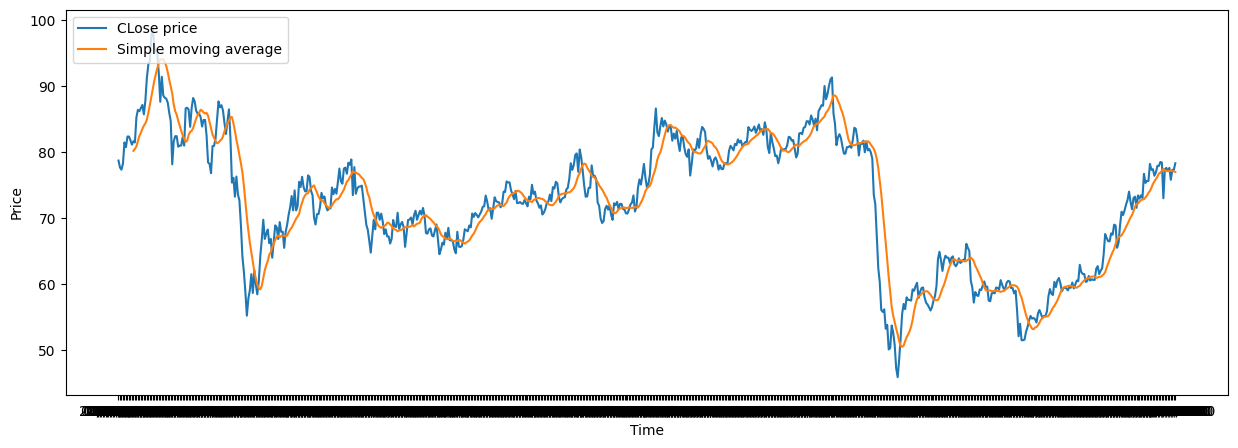

In [86]:
# thêm các cột giá trị giá đóng cửa và khối lượng giao dịch của phiên trước đó
pnj_df1['Pre_close'] = pnj_df1.loc[:,['Close']].shift(1)
pnj_df1['Pre_volume'] = pnj_df1.loc[:,['Sum_volume']].shift(1)

# tính trung bình động của giá đóng cửa một số phiên giao dịch
pnj_df1['5SMA'] = pnj_df1['Pre_close'].rolling(5).mean()
pnj_df1['10SMA'] = pnj_df1['Pre_close'].rolling(10).mean()
pnj_df1['20SMA'] = pnj_df1['Pre_close'].rolling(20).mean()

# vẽ biểu đồ giá đóng cửa và trung bình động giá đóng cửa trong 0 ngày
plt.figure(figsize=(15,5))
plt.plot(pnj_df1['Close'])
plt.plot(pnj_df1['10SMA'])
plt.title('')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['CLose price', 'Simple moving average'], loc='upper left')
plt.show()


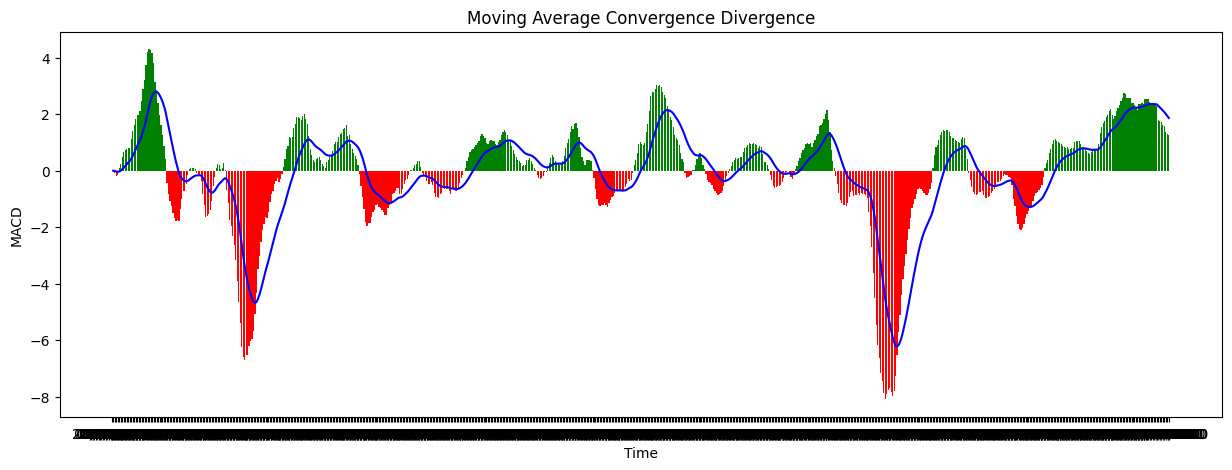

In [88]:
# tính Moving Average Convergence Divergence (MACD)
def macd(data,len1,len2,len3):
  shortEMA = data.ewm(span = len1,adjust = False).mean()
  longEMA = data.ewm(span = len2,adjust = False).mean()
  macd = shortEMA - longEMA
  signal = macd.ewm(len3,adjust = False).mean()
  return macd,signal

macd, signal = macd(pnj_df1['Pre_close'],12,26,9)
#macd, signal = macd(fpt_df['Pre_close'],3,8,6)
pnj_df1['MACD'] = macd
pnj_df1['signal_MACD'] = signal

# plot MACD
plt.figure(figsize = (15,5))
colors = np.array(['green']*len(pnj_df1['MACD']))
colors[pnj_df1['MACD']<0]='red'
plt.bar(pnj_df1.index.values,pnj_df1['MACD'],color = colors)
plt.title('')
plt.ylabel('MACD')
plt.xlabel('Time')
plt.title('Moving Average Convergence Divergence')
plt.plot(pnj_df1['signal_MACD'],color = 'blue')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

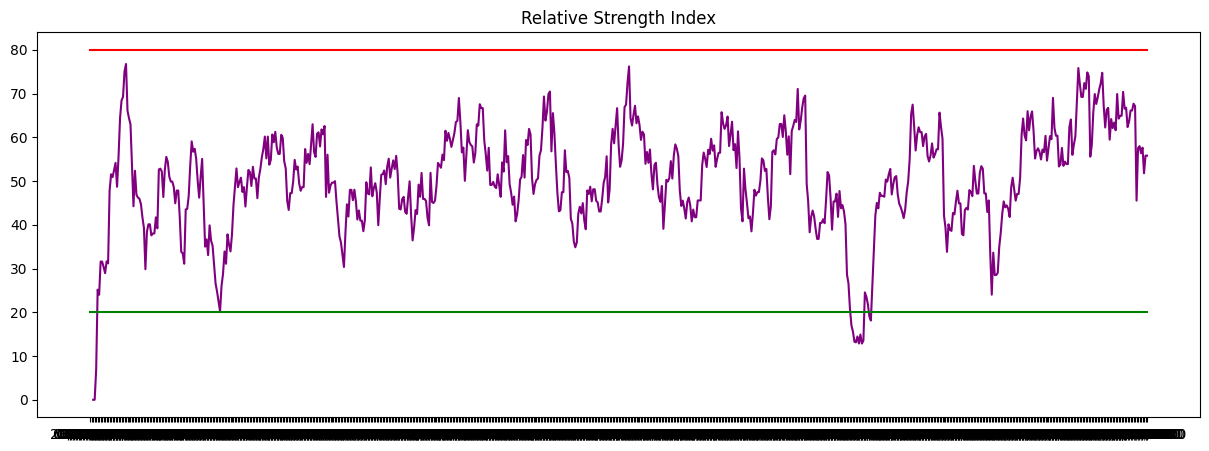

In [89]:
# tính Relative Strength Index (RSI)
def RSI(data,period):
  delta = data.diff()
  up =  delta.clip(lower=0)
  down = -1*delta.clip(upper=0)
  ema_up = up.ewm(com=period, adjust=False).mean()
  ema_down = down.ewm(com=period, adjust=False).mean()
  rs = ema_up/ema_down
  rsi = 100-(100/(1+rs))
  return rsi

pnj_df1['RSI'] = RSI(pnj_df1['Pre_close'],13)
pnj_df1['RSI_volume'] = RSI(pnj_df1['Pre_volume'],13)

x = pnj_df1.index.values
# plot RSI
plt.figure(figsize=(15,5))
plt.plot(pnj_df1['RSI'],color = 'purple')
plt.plot([x[0],x[-1]],[80,80],color='red')
plt.plot([x[0],x[-1]],[20,20],color='green')
plt.title('Relative Strength Index')
plt.show

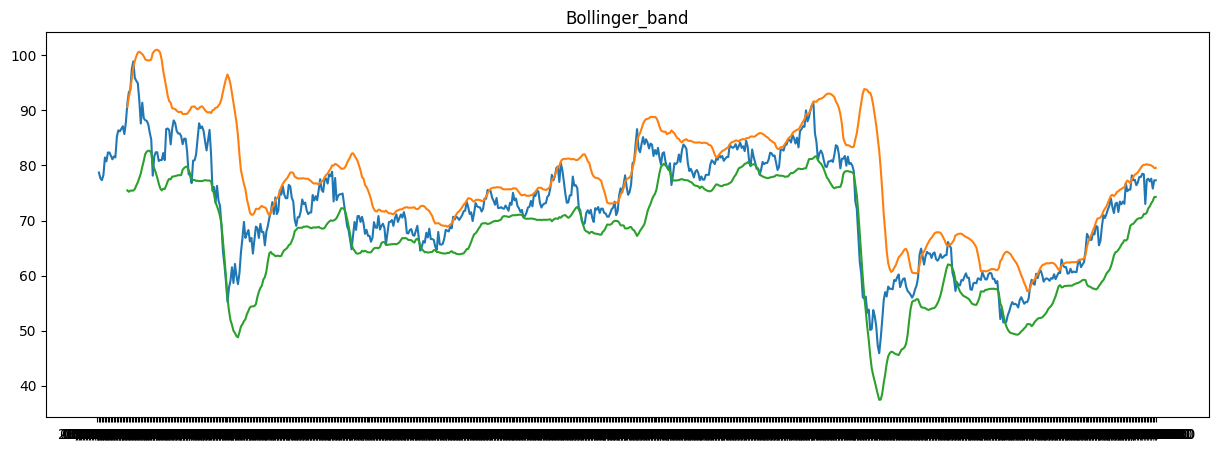

In [90]:
# tính Bollinger_band
def Bollinger_band(data,period):
  mean = data.rolling(period).mean()
  std = data.rolling(period).std()
  upper_band = np.array(mean) + 2*np.array(std)
  lower_band = np.array(mean) - 2*np.array(std)
  return upper_band, lower_band


pnj_df1['Upper_band'], pnj_df1['Lower_band'] = Bollinger_band(pnj_df1['Pre_close'],20)

# plot bollinger_band
plt.figure(figsize=(15,5))
plt.plot(pnj_df1['Pre_close'])
plt.plot(pnj_df1['Upper_band'])
plt.plot(pnj_df1['Lower_band'])
plt.title('Bollinger_band')
plt.show()

Sau khi tính toán các giá trị SMA, MACD, RSI, Bollinger_band và loại bỏ các hàng chứa giá trụ null ta được bảng dữ liệu pnj_df1 như sau:

In [91]:
# loại bỏ các hàng chứa giá trị null
pnj_df1 = pnj_df1.replace(np.inf,np.nan).dropna()
# Tính giá trị biến động giá cổ phiếu 'Fluct' theo ngày
pnj_df1['Fluct'] = (pnj_df1['Close']-pnj_df1['Pre_close'])
# Cột target này nếu giá cổ phiếu biến động tăng thì sẽ có giá trị là '1' còn không tăng hoặc giảm sẽ là '0'
pnj_df1['Target'] = (pnj_df1['Fluct'] > 0).astype(int)
pnj_df1

,Close,Sum_volume,Pre_close,Pre_volume,5SMA,10SMA,20SMA,MACD,signal_MACD,RSI,RSI_volume,Upper_band,Lower_band,Fluct,Target
Date,,,,,,,,,,,,,,,
28/03/2018,93.29,34234,91.21,26569.0,87.692,85.936,83.0565,2.462429,1.230346,64.367609,65.966509,90.641727,75.471273,2.08,1
29/03/2018,93.76,22066,93.29,34234.0,89.018,87.101,83.7855,2.879776,1.395289,68.405585,67.732624,92.351013,75.219987,0.47,1
30/03/2018,97.55,41834,93.76,22066.0,90.344,88.332,84.5905,3.211433,1.576903,69.253464,62.213283,93.738482,75.442518,3.79,1
02/04/2018,98.90,31024,97.55,41834.0,92.712,89.563,85.6015,3.737017,1.792915,75.064655,66.928212,95.781954,75.421046,1.35,1
03/04/2018,95.90,23472,98.90,31024.0,94.942,90.815,86.6325,4.213904,2.035014,76.750299,62.346815,97.817870,75.447130,-3.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16/12/2020,77.60,636190,77.10,867800.0,76.700,77.112,76.3360,1.620760,2.131517,56.351648,48.967616,80.096249,72.575751,0.50,1
17/12/2020,75.80,1289500,77.60,636190.0,76.540,77.231,76.5690,1.568966,2.075262,57.625325,46.495147,80.006918,73.131082,-1.80,0
18/12/2020,77.30,582740,75.80,1289500.0,77.100,77.120,76.6870,1.366917,2.004428,51.768719,53.610385,79.821320,73.552680,1.50,1


# Xây dựng model


Chia dữ liệu thành các tập train và test

In [92]:
# loại bỏ các cột không cần thiết để train và chia tập train, test
y = pnj_df1['Fluct'] # đầu ra của mô hình là giá trị biến động giá cổ phiếu
X = pnj_df1.drop(['Close','Sum_volume','Fluct','Target'],axis=1).values
num_test = 89 # có tổng 689 hàng vì vậy lấy 600 hàng đầy để train, 89 hàng cuối test
X_train = np.array(X[:-1*num_test])
y_train = np.array(y[:-1*num_test])
X_test = np.array(X[-1*num_test:])
y_test = np.array(y[-1*num_test:])

Xây dựng model bằng thuật toán linear regression

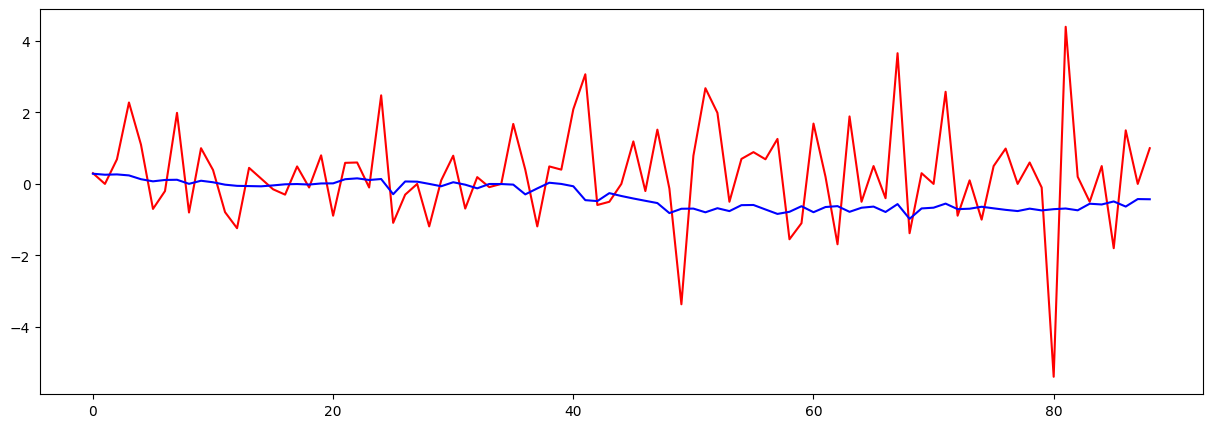

In [93]:
# Xây dựng và train model
model = LinearRegression()
model = model.fit(X_train,y_train)
predicts = model.predict(X_test)
plt.figure(figsize=(15,5))
plt.plot(y_test,color='red')
plt.plot(predicts,color='blue')
plt.show()

Từ hình trên có thể thấy đường giá trị dự đoán màu xanh không bám với đường thực tế màu đỏ nên mô hình này không khả thi

Do mô hình linear regression trên không khả thi nên em thử xây dựng mô hình dựa trên thuật toán Random Forest

In [95]:
#trong mô hình này đầu vào vẫn dữ nguyên đầu ra sẽ lấy cột 'Target' thay cho cột 'Fluct'
y1 = pnj_df1['Target']
X1 = pnj_df1.drop(['Close','Sum_volume','Fluct','Target'],axis=1).values
num_test = 89
X_train1 = np.array(X1[:-1*num_test])
y_train1 = np.array(y1[:-1*num_test])
X_test1 = np.array(X1[-1*num_test:])
y_test1 = np.array(y1[-1*num_test:])

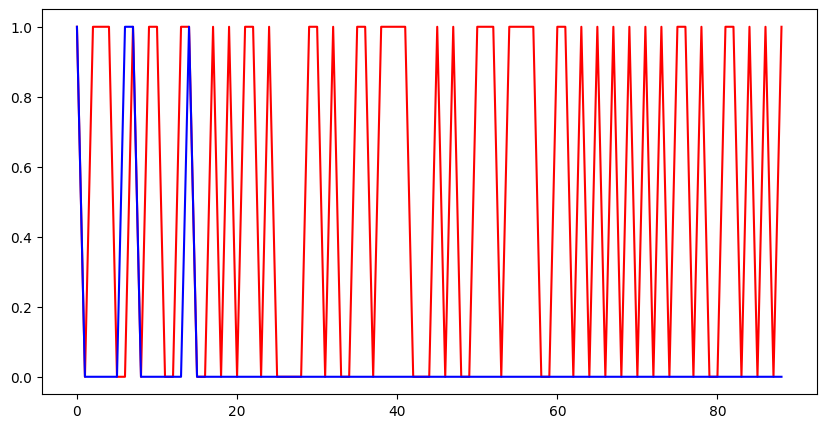

In [96]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
model1.fit(X_train1, y_train1)
y_test_predict = model1.predict(X_test1)
plt.figure(figsize=(10,5))
plt.plot(y_test1,color='red')
plt.plot(y_test_predict,color='blue')
plt.show()

Từ biểu đồ trên có thể thấy giá trị dự đoán của mô hình và giá trị thực tế không sát nhau nên mô hình này vẫn không khả thi

# Kết luận
Từ 2 mô hình trên có thể thấy việc xây dựng mô hình dự đoán trực tiếp biến động giá cổ phiếu gặp nhiều khó khăn nên ta sẽ tiếp cận theo hướng khác là dự đoán giá cổ phiếu sau đó tính toán sự biến động thông qua giá dự đoán được.